In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# to build models
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
# models for stacking
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV, RidgeCV
# for evaluation
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

import math
import warnings
warnings.simplefilter(action = 'ignore')

pd.pandas.set_option('display.max_columns', None)

In [3]:
# loading dataset
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df, df['SalePrice'], test_size = 0.25, random_state = 0)

In [5]:
# Treating missing values
# replacing missing values with mode

vars_with_na = [var for var in df.columns if x_train[var].isnull().sum() > 0 and x_train[var].dtypes != 'O']

for var in vars_with_na:
    mode_val = x_train[var].mode()[0]
    x_train[var] = x_train[var].fillna(mode_val)
    x_test[var] = x_test[var].fillna(mode_val)
    
vars_with_na = [var for var in df.columns if x_train[var].isnull().sum() > 0 and x_train[var].dtypes == 'O']
x_train[vars_with_na] = x_train[vars_with_na].fillna('Missing')
x_test[vars_with_na] = x_test[vars_with_na].fillna('Missing')

In [6]:
# removing rare labels

cat_vars = [var for var in x_train.columns if x_train[var].dtype == 'O']

def find_frequent_labels(df, var, rare_perc):
    df_copy = df.copy()
    tmp = df_copy.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
    frequent_ls = find_frequent_labels(x_train, var, 0.01)
    x_train[var] = np.where(x_train[var].isin(frequent_ls), x_train[var], 'Rare')
    x_test[var] = np.where(x_test[var].isin(frequent_ls), x_test[var], 'Rare')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
# categorical variable encoding

def replace_categories(train, test, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
    
for var in cat_vars:
    replace_categories(x_train, x_test, var, 'SalePrice')

In [8]:
x_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1292,1293,70,1,60.0,6600,1,2,0,1,1,3,0,5,2,1,4,6,5,4,1892,1965,1,0,2,2,0,0.0,1,3,3,2,3,1,5,0,4,0,994,994,1,2,0,3,1378,994,0,2372,0,0,2,0,4,2,1,11,1,0,1,4,1985.0,2,1,432,2,3,2,0,287,0,0,0,0,0,4,2,0,12,2009,2,3,107500
1018,1019,80,3,60.0,10784,1,2,1,1,1,2,0,12,2,1,4,3,7,5,1991,1992,1,0,4,4,2,76.0,2,3,4,3,3,1,5,0,4,0,384,384,1,3,1,3,802,670,0,1472,0,0,2,1,3,1,2,7,5,1,3,4,1991.0,2,2,402,2,3,2,164,0,0,0,0,0,0,4,2,0,5,2007,2,3,160000
1213,1214,80,3,60.0,10246,1,2,1,1,1,4,0,6,2,1,4,3,4,9,1965,2001,1,0,9,9,0,0.0,1,2,2,2,4,3,6,648,4,0,0,648,1,4,1,3,960,0,0,960,1,1,0,0,0,1,1,3,5,0,1,4,1965.0,1,1,364,2,3,2,88,0,0,0,0,0,0,4,2,0,5,2006,2,3,145000
1430,1431,60,3,60.0,21930,1,2,2,1,1,1,0,12,3,1,4,6,5,5,2005,2005,1,0,9,9,0,0.0,2,3,4,3,4,3,5,0,4,0,732,732,1,4,1,3,734,1104,0,1838,0,0,2,1,4,1,1,7,5,1,4,5,2005.0,3,2,372,2,3,2,100,40,0,0,0,0,0,4,2,0,7,2006,2,3,192140
810,811,20,3,78.0,10140,1,2,0,1,1,1,0,13,2,1,4,4,6,6,1974,1999,3,0,4,4,2,99.0,1,3,2,2,3,1,4,663,2,377,0,1040,1,1,1,3,1309,0,0,1309,1,0,1,1,3,1,2,5,5,1,2,4,1974.0,2,2,484,2,3,2,265,0,0,0,0,648,1,3,2,0,1,2006,2,3,181000


In [9]:
# Engineering temporal variables
def elapsed_years(df, var):
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    x_train = elapsed_years(x_train, var)
    x_test = elapsed_years(x_test, var)

In [10]:
x_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1292,1293,70,1,60.0,6600,1,2,0,1,1,3,0,5,2,1,4,6,5,4,117,44,1,0,2,2,0,0.0,1,3,3,2,3,1,5,0,4,0,994,994,1,2,0,3,1378,994,0,2372,0,0,2,0,4,2,1,11,1,0,1,4,24.0,2,1,432,2,3,2,0,287,0,0,0,0,0,4,2,0,12,2009,2,3,107500
1018,1019,80,3,60.0,10784,1,2,1,1,1,2,0,12,2,1,4,3,7,5,16,15,1,0,4,4,2,76.0,2,3,4,3,3,1,5,0,4,0,384,384,1,3,1,3,802,670,0,1472,0,0,2,1,3,1,2,7,5,1,3,4,16.0,2,2,402,2,3,2,164,0,0,0,0,0,0,4,2,0,5,2007,2,3,160000
1213,1214,80,3,60.0,10246,1,2,1,1,1,4,0,6,2,1,4,3,4,9,41,5,1,0,9,9,0,0.0,1,2,2,2,4,3,6,648,4,0,0,648,1,4,1,3,960,0,0,960,1,1,0,0,0,1,1,3,5,0,1,4,41.0,1,1,364,2,3,2,88,0,0,0,0,0,0,4,2,0,5,2006,2,3,145000
1430,1431,60,3,60.0,21930,1,2,2,1,1,1,0,12,3,1,4,6,5,5,1,1,1,0,9,9,0,0.0,2,3,4,3,4,3,5,0,4,0,732,732,1,4,1,3,734,1104,0,1838,0,0,2,1,4,1,1,7,5,1,4,5,1.0,3,2,372,2,3,2,100,40,0,0,0,0,0,4,2,0,7,2006,2,3,192140
810,811,20,3,78.0,10140,1,2,0,1,1,1,0,13,2,1,4,4,6,6,32,7,3,0,4,4,2,99.0,1,3,2,2,3,1,4,663,2,377,0,1040,1,1,1,3,1309,0,0,1309,1,0,1,1,3,1,2,5,5,1,2,4,32.0,2,2,484,2,3,2,265,0,0,0,0,648,1,3,2,0,1,2006,2,3,181000


In [11]:
# Treat non-gaussian distributed variables
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    x_train[var] = np.log(x_train[var])
    x_test[var] = np.log(x_test[var])
    
x_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1292,1293,70,1,4.094345,8.794825,1,2,0,1,1,3,0,5,2,1,4,6,5,4,117,44,1,0,2,2,0,0.0,1,3,3,2,3,1,5,0,4,0,994,994,1,2,0,3,7.228388,994,0,7.771489,0,0,2,0,4,2,1,11,1,0,1,4,24.0,2,1,432,2,3,2,0,287,0,0,0,0,0,4,2,0,12,2009,2,3,11.585246
1018,1019,80,3,4.094345,9.285819,1,2,1,1,1,2,0,12,2,1,4,3,7,5,16,15,1,0,4,4,2,76.0,2,3,4,3,3,1,5,0,4,0,384,384,1,3,1,3,6.687109,670,0,7.294377,0,0,2,1,3,1,2,7,5,1,3,4,16.0,2,2,402,2,3,2,164,0,0,0,0,0,0,4,2,0,5,2007,2,3,11.982929
1213,1214,80,3,4.094345,9.234643,1,2,1,1,1,4,0,6,2,1,4,3,4,9,41,5,1,0,9,9,0,0.0,1,2,2,2,4,3,6,648,4,0,0,648,1,4,1,3,6.866933,0,0,6.866933,1,1,0,0,0,1,1,3,5,0,1,4,41.0,1,1,364,2,3,2,88,0,0,0,0,0,0,4,2,0,5,2006,2,3,11.884489
1430,1431,60,3,4.094345,9.995611,1,2,2,1,1,1,0,12,3,1,4,6,5,5,1,1,1,0,9,9,0,0.0,2,3,4,3,4,3,5,0,4,0,732,732,1,4,1,3,6.598509,1104,0,7.516433,0,0,2,1,4,1,1,7,5,1,4,5,1.0,3,2,372,2,3,2,100,40,0,0,0,0,0,4,2,0,7,2006,2,3,12.165980
810,811,20,3,4.356709,9.224243,1,2,0,1,1,1,0,13,2,1,4,4,6,6,32,7,3,0,4,4,2,99.0,1,3,2,2,3,1,4,663,2,377,0,1040,1,1,1,3,7.177019,0,0,7.177019,1,0,1,1,3,1,2,5,5,1,2,4,32.0,2,2,484,2,3,2,265,0,0,0,0,648,1,3,2,0,1,2006,2,3,12.106252


In [12]:
# Feature scaling

train_vars = [var for var in x_train.columns if var not in ['Id', 'SalePrice']]
scaler = MinMaxScaler()
scaler.fit(x_train[train_vars])
    
    
x_train[train_vars] = scaler.transform(x_train[train_vars])
x_test[train_vars] = scaler.transform(x_test[train_vars])

print(x_train.isnull().sum().any(),x_test.isnull().sum().any())

False False


In [13]:
y_train = x_train['SalePrice']
y_test = x_test['SalePrice']

x_train.drop(['Id', 'SalePrice'], axis = 1, inplace = True)
x_test.drop(['Id', 'SalePrice'], axis = 1, inplace = True)

In [18]:
sef_ = SelectFromModel(Lasso(alpha = 0.005, random_state = 0))
sef_.fit(x_train, y_train)
selected_feats = x_train.columns[(sef_.get_support())]

print('Total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sef_.estimator_.coef_== 0)))

Total features: 79
selected features: 25
features with coefficients shrank to zero: 54


In [23]:
sef_.estimator_.coef_

array([-0.01210574,  0.04535366,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00389658,  0.        ,  0.        ,  0.        ,
        0.        ,  0.31035851,  0.        ,  0.        ,  0.        ,
        0.        ,  0.45447037,  0.00926688, -0.        , -0.11088058,
        0.00757462,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.01223436,  0.01257447,
        0.        ,  0.05238359,  0.        ,  0.16907797,  0.        ,
        0.        ,  0.        ,  0.0133371 ,  0.        ,  0.01454571,
        0.06839716,  0.        ,  0.14680553,  0.        ,  0.        ,
        0.72730074,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.09224318,  0.        ,  0.        ,
        0.04642164,  0.07279886,  0.04591513, -0.        ,  0.050284  ,
        0.14870255,  0.        ,  0.        ,  0.        ,  0.0050388 ,
        0.        ,  0.        , -0.        ,  0.        ,  0.  

In [26]:
sef_.get_params()

{'estimator__alpha': 0.005,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 1000,
 'estimator__normalize': False,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': 0,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': Lasso(alpha=0.005, random_state=0),
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': None}

In [27]:
sef_.get_support()

array([ True,  True, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
       False,  True,  True, False,  True, False,  True, False, False,
       False,  True, False,  True,  True, False,  True, False, False,
        True, False, False, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

In [29]:
params = {
    'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 5, 'learning_rate': 0.01, 'loss': 'ls'
}

GB_model = GradientBoostingRegressor(**params)
lin_model = Lasso(alpha = 0.005, random_state = 0)
RF_model = RandomForestRegressor(n_estimators = 400, random_state = 0)

estimators = [
    ('Random Forest', RF_model), ('Lasso', lin_model), ('Gradient Boosting', GB_model)
]

stacking_regressor = StackingRegressor(estimators = estimators, final_estimator = RidgeCV())

In [32]:
x_train = x_train[selected_feats]
x_test = x_test[selected_feats]
print(x_train.shape,x_test.shape)

(1095, 25) (365, 25)


In [33]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True_Price')
    ax.set_ylabel('Predicted_Price')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + 'n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

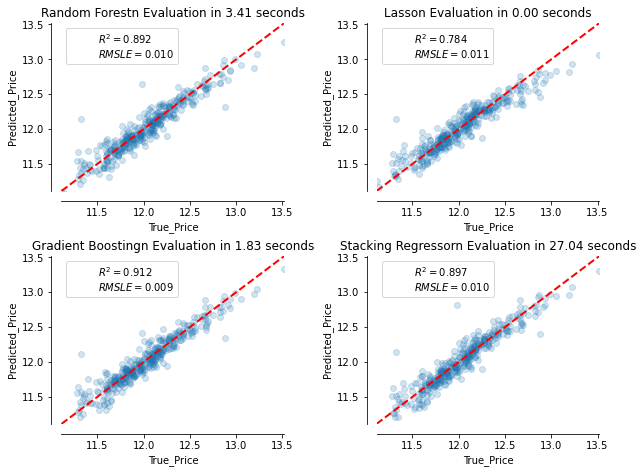

In [36]:
import time

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(x_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(x_test)
    errors = y_test - model.predict(x_test)
    errors_list.append(errors)
    test_r2= r2_score(np.exp(y_test), np.exp(pred))
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' + 
                            r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

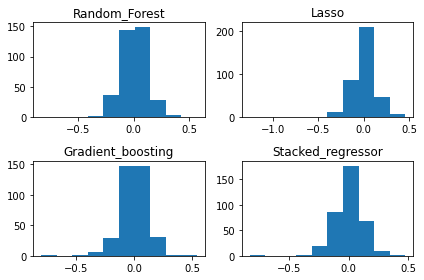

In [37]:
titles = ['Random_Forest','Lasso','Gradient_boosting','Stacked_regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()

In [ ]:
importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = selected_feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(10,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')